# 1. Loading data

In [3]:
import pandas as pd
import numpy as np

In [58]:
E_feats = pd.read_csv('features/e_feats.csv').drop('Unnamed: 0',
                                                   axis=1).rename(columns={'E_uid':'uid',
                                                                           'E_target':'target'
                                                                          }).set_index('uid')
C_feats = pd.read_csv('features/c_feats.csv',index_col=0)
EG_feats = pd.read_csv('features/eg_feats.csv',index_col=0)
CE_feats = pd.read_csv('features/ce_feats.csv',index_col=0)
CEG_feats = pd.read_csv('features/ceg_feats.csv',index_col=0)

In [16]:
target = pd.read_csv('clean_data/target_ml.csv').rename(columns={'votes_num':'target'}).set_index('uid')

In [21]:
#pd.merge(E_feats.set_index('E_uid'),target,left_index=True,right_index=True)

In [104]:
E_feats['target'].value_counts()

1    946
0    104
Name: target, dtype: int64

In [86]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, roc_auc_score,auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier as GBM
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
def draw_roc_cv(clf,X,y,average='micro',cv=10):
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=cv)
    classifier = clf

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen',
                    'yellow', 'blue', 'darkorange',
                    'green','grey','magenta','brown'])
    lw = 2

    i = 0
    plt.figure(figsize=(10,5))
    for (train, test), color in zip(cv.split(X, y), colors):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        _ = plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    _ = plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    _ = plt.plot(mean_fpr, mean_tpr, color='r', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
cnn = CondensedNearestNeighbour()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
#X_resampled, y_resampled = balancer.fit_sample(X_train, y_train)


y_pred = pipeline.fit(X_train, y_train).predict(X_test)
cmat = confusion_matrix(y_test, y_pred)
sns.heatmap(cmat/cmat.sum())

In [106]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import (EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours)
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE
threshold = 0.02 #keep for ML importances above threshold
clf = DecisionTreeClassifier(criterion='entropy')
clf = GBM(max_depth=4,n_estimators=200)
balancer = SMOTE()
enn = EditedNearestNeighbours()
renn = RepeatedEditedNearestNeighbours()
stdsc = StandardScaler()
pipeline = make_pipeline( enn, renn,stdsc, clf)
cv = 4

In [115]:
def eval_features(df,clf=GBM(), cv=5, threshold=0.02):
    ML_features =df.copy()
    X = ML_features.copy().drop(['target'],axis=1).fillna(-1).values
    y = ML_features['target'].values.copy()

    #X_resampled, y_resampled = balancer.fit_sample(X, y)
    clf.fit(X, y)
    feats = pd.Series(index=ML_features.drop(['target'],axis=1).columns.values,data=clf.steps[3][1].feature_importances_)
    cols_E = feats[feats>threshold].sort_values(ascending=False).index[:5].values.tolist()
    scores = cross_val_score(clf,X, y, cv=cv)
    draw_roc_cv(clf,X,y,average='macro',cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores_f1 = cross_val_score(clf,X, y, cv=cv, scoring='f1_macro')
    print("F1 score: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    #X_resampled, y_resampled = balancer.fit_sample(X_train, y_train)


    y_pred = clf.fit(X_train, y_train).predict(X_test)
    cmat = confusion_matrix(y_test, y_pred)
    print(cmat)
    _ = sns.heatmap(cmat,annot=True)
    return feats[feats>threshold].sort_values(ascending=False)

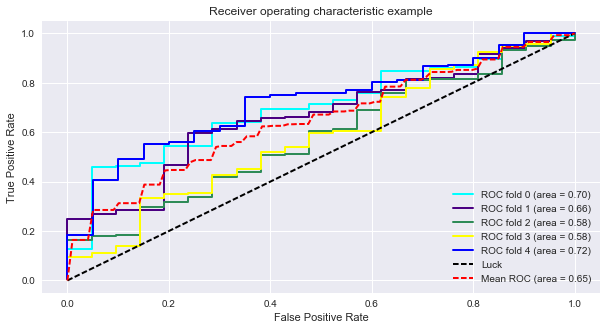

Accuracy: 0.73 (+/- 0.19)
F1 score: 0.51 (+/- 0.08)
[[  9  15]
 [ 33 153]]


E_votes_num       0.156682
E_com_sum         0.146865
E_com_mean        0.086643
E_votes_3         0.069523
E_votes_std       0.063640
E_likes_std       0.051215
E_votes_mean      0.050261
E_likes_sum       0.048553
E_likes_mean      0.047977
E_dislikes_sum    0.047322
E_com_std         0.045594
E_votes_4         0.041585
E_dislikes_std    0.038881
E_votes_2         0.028036
dtype: float64

In [116]:
eval_features(E_feats,clf=pipeline)

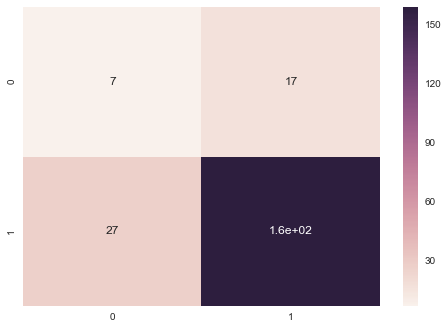

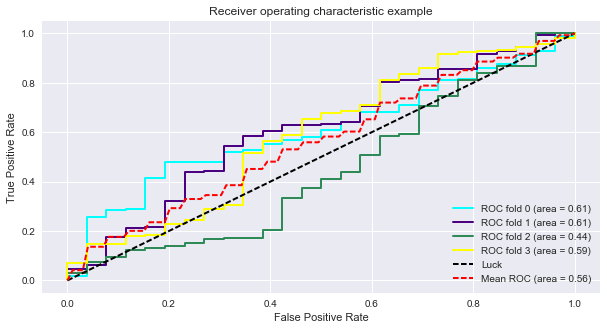

Accuracy: 0.71 (+/- 0.23)
F1 score: 0.48 (+/- 0.09)
[[  6  18]
 [ 17 169]]


CE_votes_num                                   0.066906
E_votes_num                                    0.059490
CEG_interactions_NMF2_d                        0.033443
CEG_rel_agree_w_betweenness_centrality         0.033298
CEG_interactions_w_betweenness_centrality_u    0.031369
G_interactions_NMF1_u                          0.028091
CE_votes_3                                     0.026163
CE_comid                                       0.024590
G_rel_agree_w_betweenness_centrality           0.023812
CEG_rel_agree_NMF1_d                           0.021801
G_interactions_w_betweenness_centrality_u      0.020857
dtype: float64

In [122]:
feats = pd.merge(E_feats[['target']],CEG_feats,left_index=True,right_index=True,how='outer')
feats = pd.merge(feats,E_feats.drop('target',axis=1),left_index=True,right_index=True,how='outer')
feats = pd.merge(feats,CE_feats,left_index=True,right_index=True,how='outer')
#feats = pd.merge(feats,C_feats,left_index=True,right_index=True,how='outer')
feats = pd.merge(feats,EG_feats,left_index=True,right_index=True,how='outer')
eval_features(feats,pipeline,cv=4)

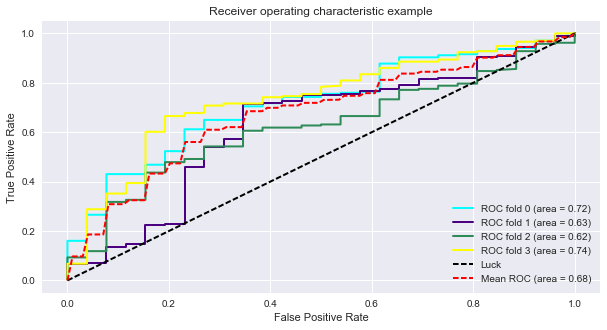

Accuracy: 0.89 (+/- 0.03)
F1 score: 0.49 (+/- 0.04)


E_votes_num        0.154828
E_votes_mean       0.104534
E_votes_std        0.091950
E_com_sum          0.074322
E_votes_3          0.067953
E_likes_std        0.063269
E_dislikes_sum     0.060969
E_dislikes_std     0.054885
E_likes_sum        0.053840
E_com_mean         0.049649
E_com_num          0.037108
E_likes_mean       0.035481
E_dislikes_mean    0.032659
E_votes_2          0.031704
E_com_std          0.026099
E_votes_1          0.019073
E_votes_4          0.016879
E_dislikes_num     0.012448
E_likes_num        0.012350
dtype: float64

In [113]:

#from imblearn.under_sampling import CondensedNearestNeighbour
#from imblearn.over_sampling import SMOTE
ML_features = E_feats.copy()
threshold = 0.02
cv = 4
X = ML_features.copy().drop(['target'],axis=1).fillna(-1).values
y = ML_features['target'].values.copy()

#X_resampled, y_resampled = balancer.fit_sample(X, y)
clf = GBM()
clf.fit(X, y)
feats = pd.Series(index=ML_features.drop(['target'],axis=1).columns.values,data=clf.feature_importances_)
cols_E = feats[feats>threshold].sort_values(ascending=False).index[:5].values.tolist()
scores = cross_val_score(clf,X, y, cv=cv)
draw_roc_cv(clf,X,y,average='macro',cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores_f1 = cross_val_score(clf,X, y, cv=cv, scoring='f1_macro')
print("F1 score: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))

feats.sort_values(ascending=False)